# Apply Text Mining Techniques on Amazon food Reviews

# Objective:

1. From the given Amazon fine food reviews data plot TSNE using NLP techinques called BAGOFWORDS, TF-IDF, WORD2VEC and AvgW2V and Weighted W2V
2. Import the necessary libraries for reading data and for data manipulation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import warnings
warnings.filterwarnings("ignore")

1. Connect the database using sqlite3 and read the sql query of Amazon Food Reviews

In [2]:
connection = sqlite3.connect('D:\\AI_stuff\\dataset\\Amazon food reviews\\database.sqlite')

food_reviews = pd.read_sql_query("select * from reviews",connection)

1. See the columns of food_reviews table 

In [3]:
print(food_reviews.columns)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


Print the 6 columns of Data

In [4]:
food_reviews.head(6)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...


When you observe the columns we have Text and Score 



From these reviews take the Score feature into consideration and give some text value to Score rather than Numeric 
now lets take reviews which scores are more than 3 and less than 3.

Find out positive or negative based on score 

In [5]:
food_reviews = pd.read_sql_query('select * from reviews where Score != 3',connection)

pos_neg = list(map(lambda x : 'Positive' if x > 3 else 'Negative',food_reviews['Score']))

food_reviews['Score'] = pos_neg

food_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning or preprocess the data

1. Drop the duplicates
2. Find the null values
3. clear the HTML tags
4. clear the punctuation
5. do the steeming and lemmatization

Sort the Data beased on product ID

In [6]:
sorted_data = food_reviews.sort_values('ProductId',axis = 0 ,inplace = False, ascending = True)

Drop the duplicates where UserId profilename time and text are same

In [7]:
remove_duplicates = sorted_data.drop_duplicates(subset = {'UserId' , 'ProfileName' , 'Time' , 'Text'} , keep = 'first' , inplace = False)

remove_duplicates.shape

(364173, 10)

Checking the features which has null values if exists do some modifications on null values

In [8]:
remove_duplicates.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

According to the given data Helpfulness Numerator should be greater than Helpfulness Denominator 

In [9]:
final_reviews = remove_duplicates[remove_duplicates['HelpfulnessNumerator'] <= remove_duplicates['HelpfulnessDenominator']]

final_reviews.shape

(364171, 10)

In [10]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop = set(stopwords.words('english')) #Stopwords set
sno = nltk.stem.SnowballStemmer('english') # snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[]
s=''
for sent in final_reviews['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_reviews['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) 
                    if(final_reviews['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1



Now lets add the final_string as new column of food_reviews

In [11]:
final_reviews['FilteredText']=final_string#add cloumn to original data set
final_reviews['FilteredText']=final_reviews['FilteredText'].str.decode("utf-8")

In [12]:
#Adding new data to DataBase
conn = sqlite3.connect('final_reviews.sqlite')
c=conn.cursor()
conn.text_factory = str
final_reviews.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [13]:
print(final_reviews.head(6))

            Id   ProductId          UserId                  ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   
138693  150511  0006641040  A1C9K534BCI9GO           Laura Purdie Salas   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  Positive   939340800   
138688                     1                       1  Positive  1194739200   
138689                     1                       1  Positive  1191456000   
138690                     1                       1  Positive  1076025600   
138691                     3                       4  Positive  1018396800   
138693

1. Now the probelm breaks into input and output feature where score column taken as output and filtered Text taken as input 
2. Based on this text data we have plot the negative and positive score

In [14]:
final_reviews_score = final_reviews['Score']

final_reviews_data  = final_reviews.drop('Score', axis=1)

final_reviews_data.shape

(364171, 10)

# Apply Bag Of Words techinique on final reviews and apply TSNE

# Bag Of Words(BoW)

1. Every Machine learning algorithm doesn't perform on Raw text we have to convert it to vectors this is called Feature Encoding
2. The Bow follows count of words from corpus to each document and forms as boolean vector for each document
3. the all documents boolean vectors forms to Sparse Matrix which 1 and 0's
4. We can think BoW follows dictionary which key value pair.

1. Using CountVectorizer function which converts documents data into matrix of token counts

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

final_data = CountVectorizer().fit(final_reviews_data['FilteredText'].values).transform(final_reviews_data['FilteredText'].values)

final_data.shape

(364171, 71624)

# T - distributed Stochastic Neighbourhood Embedding

1. T-sne is the super duper techinque for dimensionality reduction and it performs well on Large data sets
2. set perplextiy usually these neighbours count and 5 to 50 is good for tsne clustering

Due to memory sufficiency plotting 1000 and 2000 data points

In [15]:
from sklearn.manifold import TSNE
import seaborn as sn

Text(0.5,1,'The Graph shows the clusters where perplexity is 50 and iterations are 5000 to the 1000 data points')

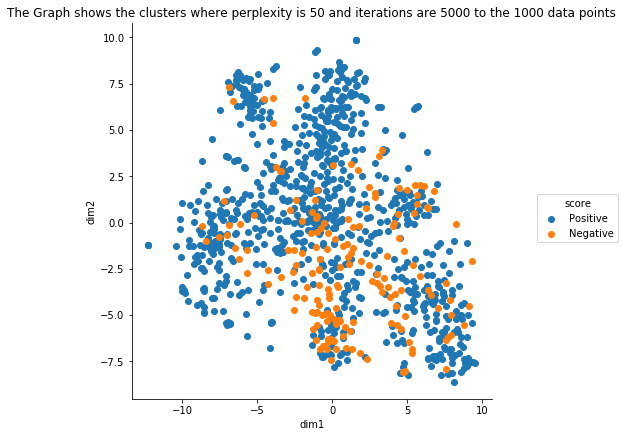

In [16]:

model = TSNE(n_components = 2 ,random_state = 0, perplexity = 50 , n_iter = 5000)

tsne_final = final_data[0:1000,:]

tsne_final_ma = tsne_final.toarray()

tsne_labels = final_reviews_score[0:1000]

tsne_data = model.fit_transform(tsne_final_ma)

tsne_data = np.vstack((tsne_data.T,tsne_labels)).T

tsne = pd.DataFrame(tsne_data, columns = ('dim1','dim2','score'))

(sn.FacetGrid(tsne,hue = 'score',size = 6).map(plt.scatter,'dim1','dim2').add_legend())

plt.title("The Graph shows the clusters where perplexity is 50 and iterations are 5000 to the 1000 data points")

Text(0.5,1,'The Graph shows the clusters where perplexity is 30 and iterations are 5000 to the 2000 data points')

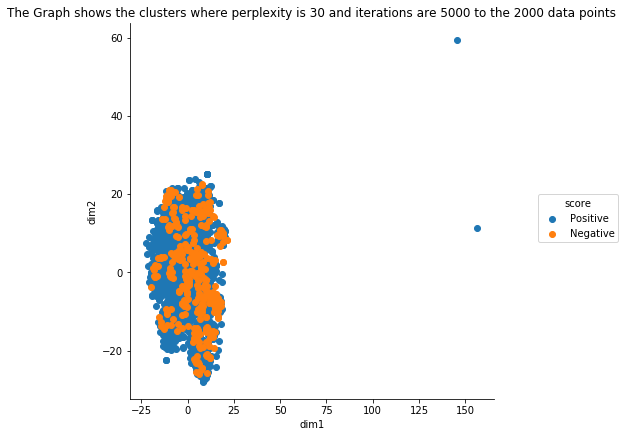

In [19]:
model  = TSNE(n_components = 2, random_state = 0, perplexity = 30 , n_iter = 5000)

tsne_data = final_data[0:2000,:]

tsne_final = tsne_data.toarray()

tsne_score= final_reviews_score[0:2000]

tsne_final_data = model.fit_transform(tsne_final)

tsne_final_data = np.vstack((tsne_final_data.T,tsne_score)).T

tsne_df = pd.DataFrame(tsne_final_data, columns = ('dim1' , 'dim2' , 'score' ))

(sn.FacetGrid(tsne_df, hue = 'score' , size=6).map(plt.scatter,'dim1','dim2').add_legend())

plt.title("The Graph shows the clusters where perplexity is 30 and iterations are 5000 to the 2000 data points")

# Apply TFIDF technique then apply on tsne

1. It is called Trem Frequent - Inverse Data Frequency

Term Frequency: Number of words appear in the word document to total number of words on corpus

Inverse Document Corpus:Used to calculate weight of rare in entire corpus

Tfidfvectorizer : Converts as Raw text to TFIDF features

same as countvectorizer but with TFIDF features

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(ngram_range = (1,2))

tfidf = tfidf_vector.fit_transform(final_reviews_data['FilteredText'])

tfidf.shape


(364171, 2923725)

In [24]:
tfidf_fea_names = tfidf_vector.get_feature_names()
len(tfidf_fea_names)

2923725

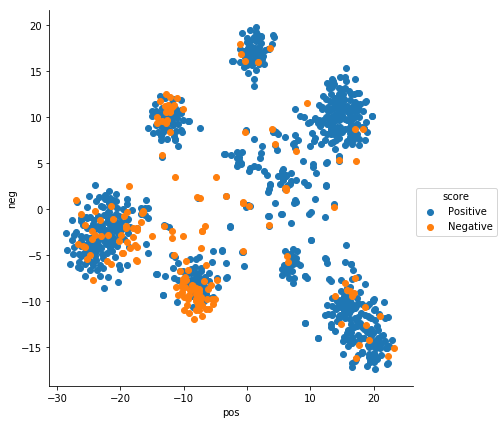

In [17]:
model  =  TSNE(n_components = 2, random_state = 0, perplexity = 50, n_iter = 5000)

tsne_final = tfidf[0:1000,:]

tsne_final_data = tsne_final.toarray()

tsne_labels = final_reviews_score[0:1000]

tsne_data = model.fit_transform(tsne_final_data)

tsne = np.vstack((tsne_data.T,tsne_labels)).T

tsne_df = pd.DataFrame(tsne, columns = ('pos','neg','score'))

(sn.FacetGrid(tsne_df,hue = 'score',size = 6).map(plt.scatter,'pos','neg').add_legend())

plt.title("The Graph shows the clusters where perplexity is 50 and iterations are 5000 to the 1000 data points")

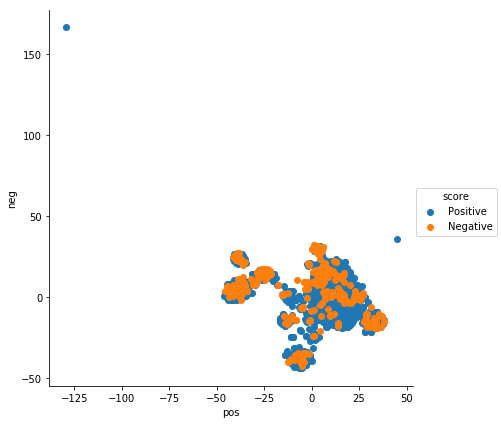

In [18]:
model  =  TSNE(n_components = 2, random_state = 0, perplexity = 30, n_iter = 5000)

tsne_final = tfidf[0:2000,:]

tsne_final_data = tsne_final.toarray()

tsne_labels = final_reviews_score[0:2000]

tsne_data = model.fit_transform(tsne_final_data)

tsne = np.vstack((tsne_data.T,tsne_labels)).T

tsne_df = pd.DataFrame(tsne, columns = ('pos','neg','score'))

(sn.FacetGrid(tsne_df,hue = 'score',size = 6).map(plt.scatter,'pos','neg').add_legend())

plt.title("The Graph shows the clusters where perplexity is 30 and iterations are 5000 to the 2000 data points")

# Apply TSNE on WORD2VEC

# Word2Vec

1. It takes large corpus text as input and produces a vector space
2. in the vector space the text has same similarity are located with close proximity

In [16]:
list_sente = []

for sent in final_reviews_data['FilteredText'].values:
    list_sente.append(sent.split())
print(list_sente[0])    

['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [17]:
import gensim
from gensim.models import Word2Vec
w2vModel  = Word2Vec(list_sente,min_count=5,workers=10,size=100)

word2vec = w2vModel[w2vModel.wv.vocab]

print(word2vec.shape)
print(final_reviews_score.shape)

print(word2vec[0])

D:\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(21938, 100)
(364171,)
[-0.00920736 -0.09257048 -0.05511234 -0.07684173  0.06356979 -0.07873904
 -0.10254264 -0.07425691 -0.08196351  0.01944411  0.0333006  -0.13199142
 -0.04689119 -0.00218844 -0.10449031  0.05171609 -0.01618409 -0.04037449
 -0.01624913 -0.00069948 -0.09518725 -0.14778852  0.09723819 -0.05238622
  0.10636167  0.01146154  0.08188266  0.12316296 -0.02802126  0.12534551
 -0.12437954 -0.05806489 -0.05503935 -0.07768691  0.05876024 -0.02038354
  0.00671087  0.05054863  0.05361281  0.04172159  0.18627982 -0.0251293
  0.08756302 -0.00109687  0.18974766  0.03756736 -0.03169302  0.09475686
 -0.11756644 -0.05128342 -0.07379335 -0.00620727 -0.03752125  0.02317949
 -0.0379058   0.01199759  0.1602975  -0.01603093 -0.14213265 -0.00177082
 -0.19430514  0.14256094  0.03871239 -0.05334643  0.00273894 -0.03843382
  0.05681704  0.12442424  0.09912951 -0.06662779  0.10728484 -0.05650352
  0.0854284   0.00241025  0.11501122 -0.05817017 -0.10038203  0.10617981
  0.04942359 -0.02576938  0.0

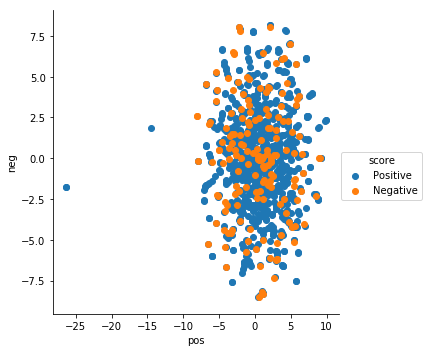

In [27]:
tsne_model = TSNE(n_components = 2, random_state= 0 ,perplexity = 50, n_iter = 5000)

tsne_data = word2vec[0:1000]


tsne_label = final_reviews_score[0:1000]

tsne_final = tsne_model.fit_transform(tsne_data)

tsne_final_data = np.vstack((tsne_final.T,tsne_label)).T

tsne_df = pd.DataFrame(tsne_final_data, columns=  ('pos','neg','score'))

(sn.FacetGrid(tsne_df, hue = 'score', size = 5).map(plt.scatter,'pos','neg').add_legend())

plt.title("The Graph shows the clusters where perplexity is 50 and iterations are 5000 to the 1000 data points")

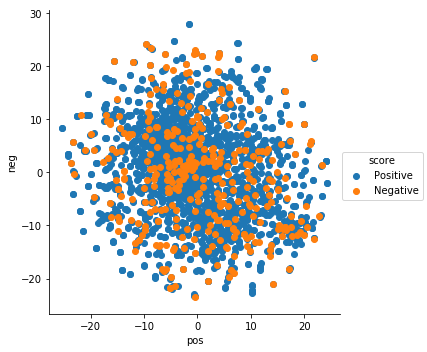

In [32]:
tsne_model = TSNE(n_components = 2, random_state= 0 ,perplexity = 30, n_iter = 5000)

tsne_data = word2vec[0:2000]


tsne_label = final_reviews_score[0:2000]

tsne_final = tsne_model.fit_transform(tsne_data)

tsne_final_data = np.vstack((tsne_final.T,tsne_label)).T

tsne_df = pd.DataFrame(tsne_final_data, columns=  ('pos','neg','score'))

(sn.FacetGrid(tsne_df, hue = 'score', size = 5).map(plt.scatter,'pos','neg').add_legend())

plt.title("The Graph shows the clusters where perplexity is 30 and iterations are 5000 to the 2000 data points")

# Applying Average Word2vec

In [18]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_sente: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in word2vec:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

Text(0.5,1,'The Graph shows the clusters where perplexity is 50 and iterations are 5000 to the 1000 data points')

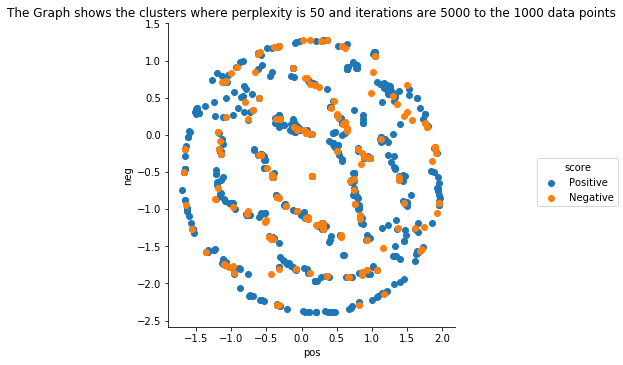

In [42]:
tsne_model = TSNE(n_components = 2, random_state= 0 ,perplexity = 50, n_iter = 5000)

tsne_data = sent_vectors[0:1000]


tsne_label = final_reviews_score[0:1000]

tsne_final = tsne_model.fit_transform(tsne_data)

tsne_final_data = np.vstack((tsne_final.T,tsne_label)).T

tsne_df = pd.DataFrame(tsne_final_data, columns=  ('pos','neg','score'))

(sn.FacetGrid(tsne_df, hue = 'score', size = 5).map(plt.scatter,'pos','neg').add_legend())

plt.title("The Graph shows the clusters where perplexity is 50 and iterations are 5000 to the 1000 data points")

Text(0.5,1,'The Graph shows the clusters where perplexity is 30 and iterations are 5000 to the 2000 data points')

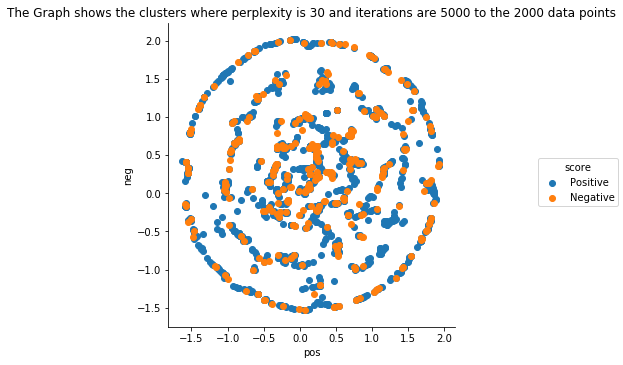

In [21]:
tsne_model = TSNE(n_components = 2, random_state= 0 ,perplexity = 30, n_iter = 5000)

tsne_data = sent_vectors[0:2000]


tsne_label = final_reviews_score[0:2000]

tsne_final = tsne_model.fit_transform(tsne_data)

tsne_final_data = np.vstack((tsne_final.T,tsne_label)).T

tsne_df = pd.DataFrame(tsne_final_data, columns=  ('pos','neg','score'))

(sn.FacetGrid(tsne_df, hue = 'score', size = 5).map(plt.scatter,'pos','neg').add_legend())
plt.title("The Graph shows the clusters where perplexity is 30 and iterations are 5000 to the 2000 data points")

# TFIDF weighted Word2vec

Based on terms of words document to corpus weights will be taken

In [25]:
tfidf_fea_names = tfidf_vector.get_feature_names()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_sente: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in word2vec:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

Text(0.5,1,'The Graph shows the clusters where perplexity is 50 and iterations are 5000 to the 1000 data points')

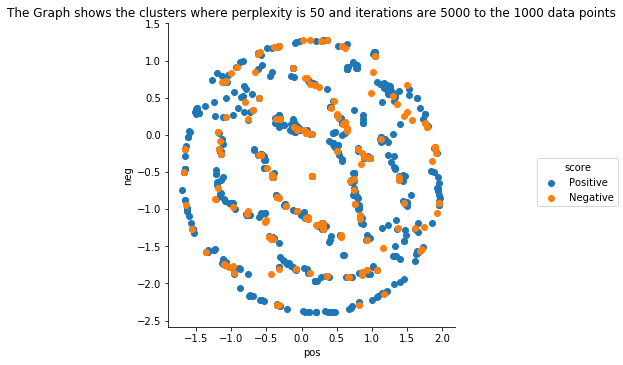

In [26]:
tsne_model = TSNE(n_components = 2, random_state= 0 ,perplexity = 50, n_iter = 5000)

tsne_data = tfidf_sent_vectors[0:1000]


tsne_label = final_reviews_score[0:1000]

tsne_final = tsne_model.fit_transform(tsne_data)

tsne_final_data = np.vstack((tsne_final.T,tsne_label)).T

tsne_df = pd.DataFrame(tsne_final_data, columns=  ('pos','neg','score'))

(sn.FacetGrid(tsne_df, hue = 'score', size = 5).map(plt.scatter,'pos','neg').add_legend())

plt.title("The Graph shows the clusters where perplexity is 50 and iterations are 5000 to the 1000 data points")

Text(0.5,1,'The Graph shows the clusters where perplexity is 30 and iterations are 5000 to the 3000 data points')

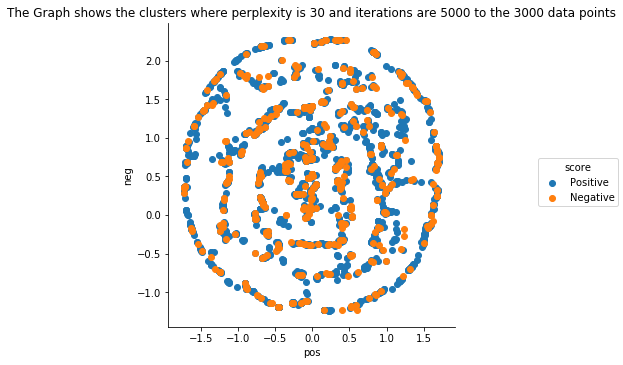

In [28]:
tsne_model = TSNE(n_components = 2, random_state= 0 ,perplexity = 30, n_iter = 5000)

tsne_data = tfidf_sent_vectors[0:3000]


tsne_label = final_reviews_score[0:3000]

tsne_final = tsne_model.fit_transform(tsne_data)

tsne_final_data = np.vstack((tsne_final.T,tsne_label)).T

tsne_df = pd.DataFrame(tsne_final_data, columns=  ('pos','neg','score'))

(sn.FacetGrid(tsne_df, hue = 'score', size = 5).map(plt.scatter,'pos','neg').add_legend())

plt.title("The Graph shows the clusters where perplexity is 30 and iterations are 5000 to the 3000 data points")